<a href="https://colab.research.google.com/github/AVMelchekova/MIPT/blob/master/%D0%9C%D0%B5%D0%BB%D1%8C%D1%87%D0%B5%D0%BA%D0%BE%D0%B2%D0%B0_%D0%90_%D0%92_%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_2_%D0%90%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ЗАДАЧА

В приложенных файлах вы увидите данные по прохождению студентами тестов на образовательной платформе. Такие данные могут быть использованы для построения персонализированных ИИ-ассистентов для поддержки обучения студента. На текущем этапе сосредоточимся на начальном этапе — сборе и подготовке данных.


ВАМ НЕОБХОДИМО:

Используя библиотеку pandas (или аналоги), проанализировать как можно больше характеристик, влияющих на успеваемость студентов.


https://www.kaggle.com/competitions/riiid-test-answer-prediction/data

Для выполнения задания вам необходимы файлы train.csv, lectures.csv, questions.csv.

 __Описание данных__

Данные были взяты из каггл соревнования и представляют собой вопросы
и лекции в рамках Test of English for International Communication(TOEIC).
Тест английского языка для международного общения - это международный стандартизированный тест на знание английского языка для лиц, не
являющихся носителями языка. Он специально разработан для измерения
повседневных навыков владения английским языком людей, работающих в
международной среде. Существуют различные формы экзамена TOEIC, в нашем случае это TOEIC Listening Reading, который состоит из двух одинаково градуированных тестов оценки понимания деятельности на общую сумму
возможных 990 баллов. В датасете 100 миллионов взаимодействий студента с
вопросами или лекциями. Данные взаимодействия описаны тремя таблицами:

`TRAIN.CSV:`

Это основная таблица, которая связывает студента с вопросом или лекцией, с которыми он взаимодействует, а также дополнительная информация
об этом взаимодействии. Список колонок и краткое их описание:

* row_id: (int64) порядковый номер строки в этой таблице.
* timestamp: (int64) время в миллисекундах между текущим взаимодействием и первым событием связанным с данным ученика.
* user_id: (int32) идентификационный код ученика.
* content_id: (int16) идентификационный код вопроса или лекции.
* content_type_id: (int8) 0 если это вопрос, 1 если лекция.
* task_container_id: (int16) идентификационный код группы вопросов, в которой задан текущий вопрос.
* user_answer: (int8) вариант ответа, который выбрал ученик. Всего вариантов может быть 4. В случае если взаимодействие - это лекция, а не вопрос, то данное поле равно -1.
* answered_correctly: (int8) правильно ли ученик ответил на вопрос. В случае, если взаимодействие - это лекция, а не вопрос, то данное поле равно -1. Данное поле нужно будет предсказывать.
* prior_question_elapsed_time: (float32) среднее время в миллисекундах, которое ученику потребовалось, чтобы ответить на все вопросы в предыдущей группе, игнорируя любые лекции между ними. Равен 0 для первой группы вопросов, заданной ученику.
* prior_question_had_explanation: (bool) смотрел ли ученик объяснение и правильный ответ на предыдущий вопрос.

`QUESTIONS.CSV:`

Таблица описывающая вопрос. Количество вопросов в отличии от количества учеников заранее зафиксировано, также задания повторно предлагаются
различным ученикам. Список колонок:

* question_id: внешний ключ(foreign key) для связывание данной информации с таблицей train.
* bundle_id: код по которому вопросы объединяются в группы.
* correct_answer: правильный ответ на вопрос.
* part: один из семи типов вопросов TOEIC. Ниже будет краткое описание каждого
* tags: один или несколько кодов с тэгами для данного вопроса. Описание тэгов не представлено, но самих кодов достаточно для того, чтобы
сделать кластеризацию.

`LECTIONS.CSV`

Данная таблица аналогична таблице про вопросы, но она про лекции,
перейдем к ее описанию:

* lecture_id: внешний ключ(foreign key) для связывание данной информации с таблицей train.
* type_of: краткое описание основной цели лекции.
* part: один из семи типов, который был в таблице с вопросами.
* tag: один тэг в качестве числа, который представляет лекцию, его значение не дано, также как и в вопросах.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import gc 
import warnings 
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = [18,10]
plt.style.use('ggplot')

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [62]:
dtypes = {
    "row_id": "int64",
    "timestamp": "int64",
    "user_id": "int32",
    "content_id": "int16",
    "content_type_id": "int8",
    "task_container_id": "int16",
    "user_answer": "int8",
    "answered_correctly": "int8",
    "prior_question_elapsed_time": "float32", 
    "prior_question_had_explanation": "boolean"
}

data = pd.read_csv("gdrive/MyDrive/Colab Notebooks/DZ_2/train.csv", dtype=dtypes, nrows=10000000)

print("Train size:", data.shape)

Train size: (10000000, 10)


In [4]:
questions = pd.read_csv('gdrive/MyDrive/Colab Notebooks/DZ_2/questions.csv')
lectures = pd.read_csv('gdrive/MyDrive/Colab Notebooks/DZ_2/lectures.csv')

Я взала данные для анализа на 10 000 000 строк и 10 колонок.

In [5]:
data.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,<NA>
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int32  
 3   content_id                      int16  
 4   content_type_id                 int8   
 5   task_container_id               int16  
 6   user_answer                     int8   
 7   answered_correctly              int8   
 8   prior_question_elapsed_time     float32
 9   prior_question_had_explanation  boolean
dtypes: boolean(1), float32(1), int16(2), int32(1), int64(2), int8(3)
memory usage: 314.7 MB


In [7]:
data.isna().sum()

row_id                                 0
timestamp                              0
user_id                                0
content_id                             0
content_type_id                        0
task_container_id                      0
user_answer                            0
answered_correctly                     0
prior_question_elapsed_time       234784
prior_question_had_explanation     39388
dtype: int64

Уникальных user_id 39491.

In [9]:
data.user_id.nunique()

39491

Content_type_id = 0 означает, что был задан вопрос. 1 означает, что пользователь смотрел лекцию.

In [10]:
data.content_type_id.value_counts()

0    9804604
1     195396
Name: content_type_id, dtype: int64

In [63]:
print(f'В таблице {data.content_id.nunique()} id, из которых {data[data.content_type_id == False].content_id.nunique()} вопросы.')

В таблице 13749 id, из которых 13500 вопросы.


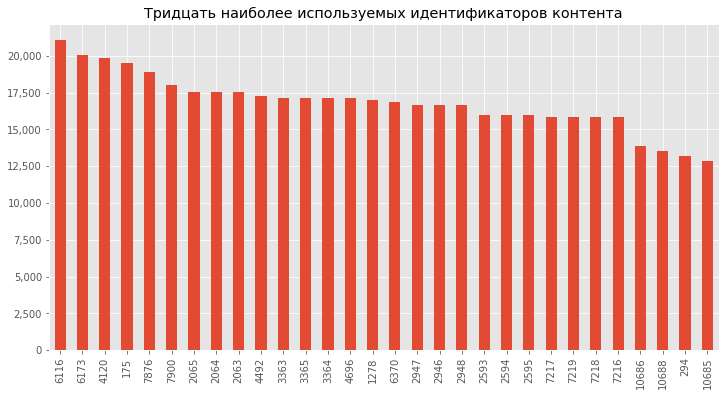

In [12]:
cids = data.content_id.value_counts()[:30]

fig = plt.figure(figsize=(12,6))
ax = cids.plot.bar()
plt.title("Тридцать наиболее используемых идентификаторов контента")
plt.xticks(rotation=90)
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

task_container_id: (int16) Идентификационный код пакета вопросов или лекций. Например, пользователь может увидеть три вопроса подряд, прежде чем увидеть объяснения к любому из них. Все три вопроса будут иметь общий идентификатор task_container_id.

In [13]:
data.task_container_id.nunique()

10000

Давайте посмотрим на самые популярные задачи.

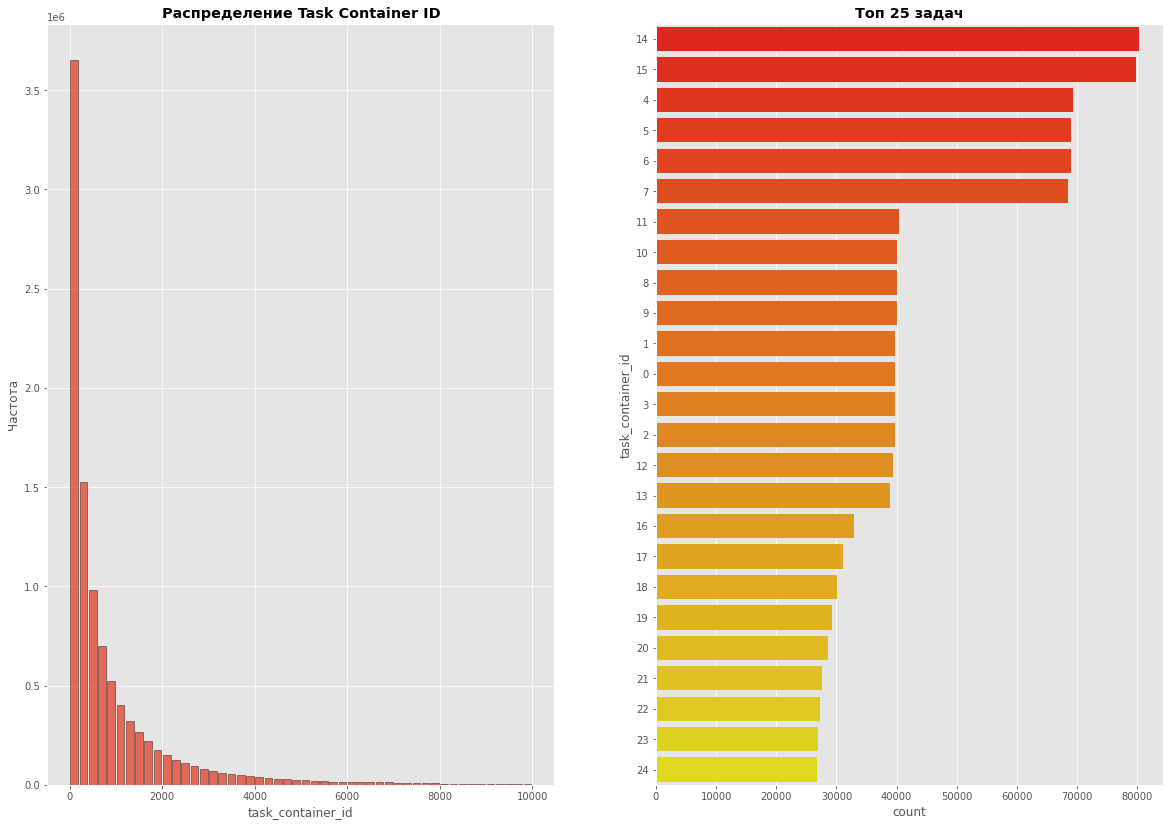

In [14]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20,14))

sns.distplot(data.task_container_id, kde=False,hist_kws={
                 'rwidth': 0.85,
                 'edgecolor': 'black',
                 'alpha': 0.8}, ax=ax[0])


ax[0].set_ylabel('Частота')
ax[0].set_title('Распределение Task Container ID', weight='bold')

sns.countplot(y='task_container_id', data=data, order=data.task_container_id.value_counts().index[:25], palette='autumn', ax=ax[1])
ax[1].set_title('Топ 25 задач', weight='bold')


plt.show()

user_answer. Похоже, что вопросы имеют множественный выбор (ответы 0-3). Как указано в описании данных, -1 - это фактически отсутствие ответа (так как взаимодействие было лекцией, а не вопросом).

In [15]:
data.user_answer.value_counts()

 0    2784028
 1    2660660
 3    2579528
 2    1780388
-1     195396
Name: user_answer, dtype: int64

Здесь видно, что вариант ответа под номером 2 встречается реже, чем остальные из трех ответов. Похоже, что пользователям /инструкторам не очень нравится вариант № 2.

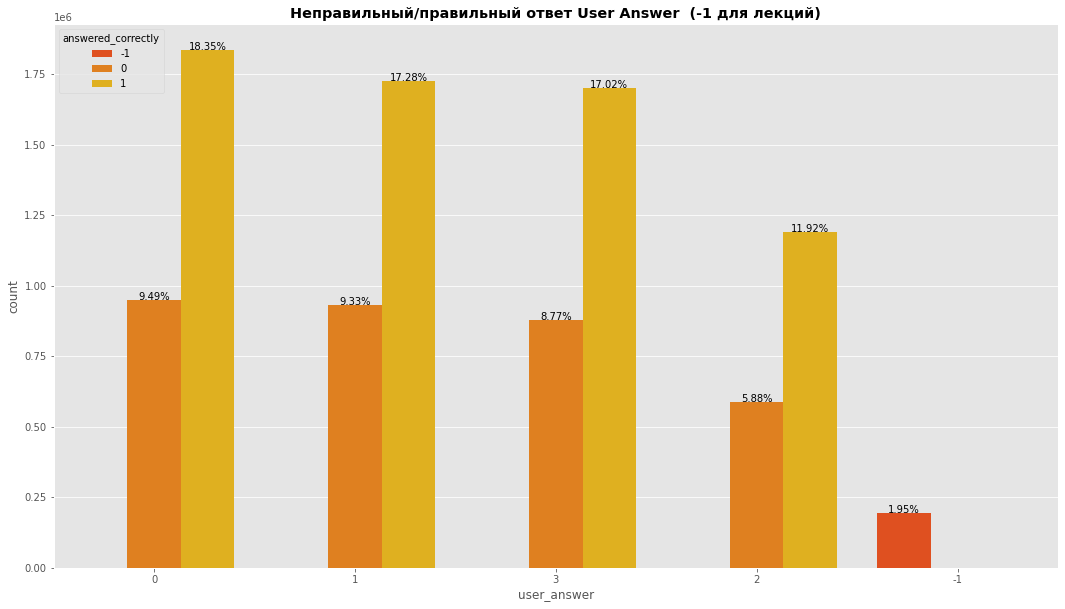

In [16]:
g=sns.countplot(data.user_answer, hue=data.answered_correctly, palette='autumn', order=data.user_answer.value_counts().index)

total = float(len(data['user_answer']))

for p in g.patches:
    height = p.get_height()
    g.text(p.get_x() + p.get_width() / 2.,
            height + 2,
            '{:1.2f}%'.format((height / total) * 100),
            ha='center')

plt.title('Неправильный/правильный ответ User Answer  (-1 для лекций)', weight='bold')

plt.show()

timestamp: (int64) время в миллисекундах между этим взаимодействием пользователя и первым завершением события от этого пользователя. Как вы можете видеть, большинство взаимодействий происходит от пользователей, которые еще не очень долго были активны на платформе.

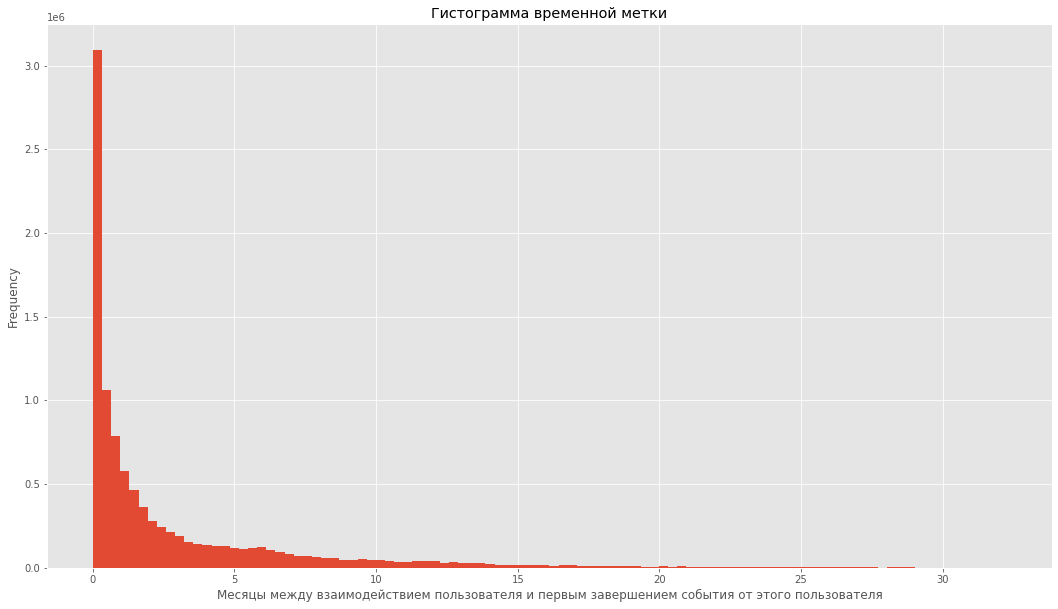

In [21]:
#1 год = 31536000000 мс
ts = data['timestamp']/(31536000000/12)

ts.plot.hist(bins=100)
plt.title("Гистограмма временной метки")
plt.xticks(rotation=0)
plt.xlabel("Месяцы между взаимодействием пользователя и первым завершением события от этого пользователя")
plt.show()

Если мы отфильтруем данные по timestamp==0, то получим время 0 для всех пользователей.

In [22]:
print(f'Из {data.user_id.nunique()} пользователей в data мы имеем {data[data.timestamp == 0].user_id.nunique()} пользователей с нулевой строкой timestamp.')

Из 39491 пользователей в data мы имеем 39491 пользователей с нулевой строкой timestamp.


Answered_correctly - это правильно отвеченные вопросы. Не глядя на взаимодействие лекций (-1), мы видим, что примерно 1/3 вопросов была отвечена неправильно.

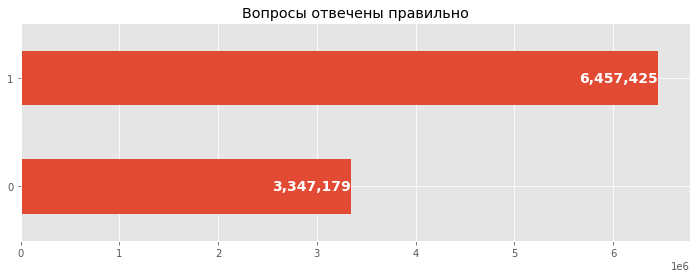

In [23]:
correct = data[data.answered_correctly != -1].answered_correctly.value_counts(ascending=True)

fig = plt.figure(figsize=(12,4))
correct.plot.barh()
for i, v in zip(correct.index, correct.values):
    plt.text(v, i, '{:,}'.format(v), color='white', fontweight='bold', fontsize=14, ha='right', va='center')
plt.title("Вопросы отвечены правильно")
plt.xticks(rotation=0)
plt.show()

Существует ли связь между timestamp и answered_correctly? Чтобы выяснить это, я разбила на 5 частей timestamp. Как вы можете видеть, единственная заметная вещь - это то, что пользователи, которые зарегистрировались относительно недавно, работают немного хуже, чем пользователи, которые активны дольше.

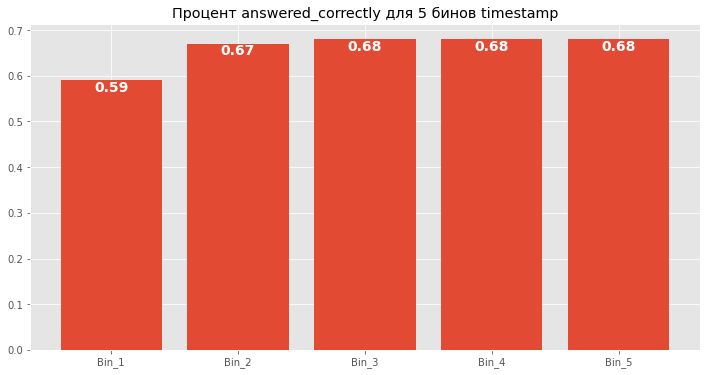

In [24]:
bin_labels_5 = ['Bin_1', 'Bin_2', 'Bin_3', 'Bin_4', 'Bin_5']
data['ts_bin'] = pd.qcut(data['timestamp'], q=5, labels=bin_labels_5)

def correct(field):
    correct = data[data.answered_correctly != -1].groupby([field, 'answered_correctly'], as_index=False).size()
    correct = correct.pivot(index= field, columns='answered_correctly', values='size')
    correct['Percent_correct'] = round(correct.iloc[:,1]/(correct.iloc[:,0] + correct.iloc[:,1]),2)
    correct = correct.sort_values(by = "Percent_correct", ascending = False)
    correct = correct.iloc[:,2]
    return(correct)

bins_correct = correct("ts_bin")
bins_correct = bins_correct.sort_index()

fig = plt.figure(figsize=(12,6))
plt.bar(bins_correct.index, bins_correct.values)
for i, v in zip(bins_correct.index, bins_correct.values):
    plt.text(i, v, v, color='white', fontweight='bold', fontsize=14, va='top', ha='center')
plt.title("Процент answered_correctly для 5 бинов timestamp")
plt.xticks(rotation=0)
plt.show()

Давайте также проверим, как выглядит распределение answered_correctly, если сгруппировать по (10 000 уникальных) task_container_id.

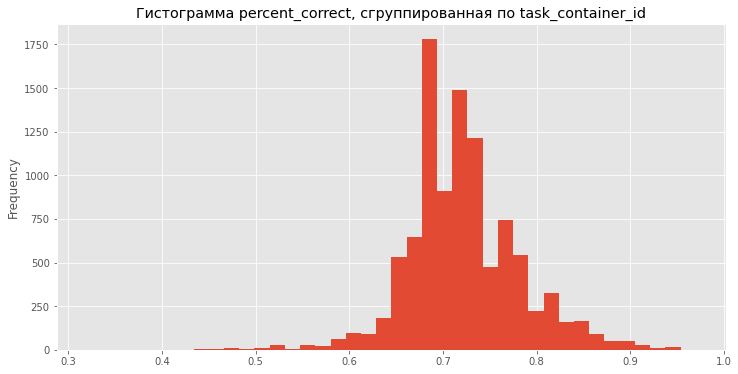

In [25]:
task_id_correct = correct("task_container_id")

fig = plt.figure(figsize=(12,6))
task_id_correct.plot.hist(bins=40)
plt.title("Гистограмма percent_correct, сгруппированная по task_container_id")
plt.xticks(rotation=0)
plt.show()

Ниже я строю график зависимости количества ответов на каждый идентификатор пользователя от процента правильно отвеченных вопросов (выборка из 200). Поскольку некоторые пользователи ответили на огромное количество вопросов, я убрала выбросы (идентификаторы пользователей с 1000+ ответами на вопросы). Как вы можете видеть, тенденция к росту, но есть также большой разброс среди пользователей, которые ответили на небольшое количество вопросов.

In [26]:
user_percent = data[data.answered_correctly != -1].groupby('user_id')['answered_correctly'].agg(Mean='mean', Answers='count')
print(f'наибольшее количество вопросов, на которые ответил пользователь, равно {user_percent.Answers.max()}')

наибольшее количество вопросов, на которые ответил пользователь, равно 15562


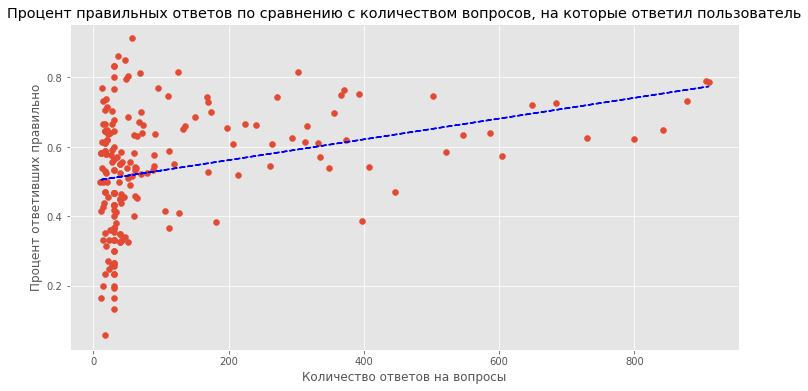

In [34]:
user_percent = user_percent.query('Answers <= 1000').sample(n=200, random_state=1)

fig = plt.figure(figsize=(12,6))
x = user_percent.Answers
y = user_percent.Mean
plt.scatter(x, y, marker='o')
plt.title("Процент правильных ответов по сравнению с количеством вопросов, на которые ответил пользователь")
plt.xticks(rotation=0)
plt.xlabel("Количество ответов на вопросы")
plt.ylabel("Процент ответивших правильно")
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"b--")

plt.show()

Ниже я делаю то же самое по content_id. Я снова беру выборку из 200, и убираю те content_id, в которых было задано более 15 000 вопросов. Как вы можете видеть, наблюдается тенденция к снижению.

In [29]:
content_percent = data[data.answered_correctly != -1].groupby('content_id')['answered_correctly'].agg(Mean='mean', Answers='count')
print(f'Наибольшее количество вопросов, заданных по content_id, равно {content_percent.Answers.max()}.')
print(f'Из {len(content_percent)} content_ids, {len(content_percent[content_percent.Answers > 15000])} content_ids было задано более 15 000 вопросов.')

Наибольшее количество вопросов, заданных по content_id, равно 21103.
Из 13500 content_ids, 26 content_ids было задано более 15 000 вопросов.


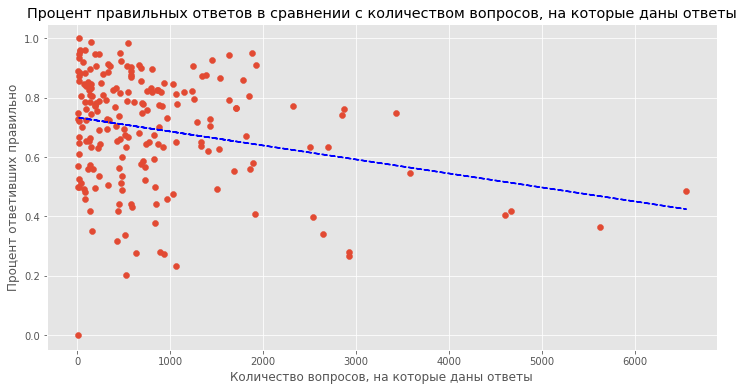

In [38]:
content_percent = content_percent.query('Answers <= 15000').sample(n=200, random_state=1)

fig = plt.figure(figsize=(12,6))
x = content_percent.Answers
y = content_percent.Mean
plt.scatter(x, y, marker='o')
plt.title("Процент правильных ответов в сравнении с количеством вопросов, на которые даны ответы")
plt.xticks(rotation=0)
plt.xlabel("Количество вопросов, на которые даны ответы")
plt.ylabel("Процент ответивших правильно")
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"b--")

plt.show()

Помогает ли, если у предыдущего вопроса было объяснение? Да, как вы видите, процент правильно ответивших примерно на 17% выше, когда было объяснение. 

Кроме того, интересно видеть, что процент правильно ответивших на вопросы с отсутствующими значениями ближе к True, чем к False.

prior_question_had_explanation
False     909661
True     8855555
NaN        39388
Name: (answered_correctly, count), dtype: int64


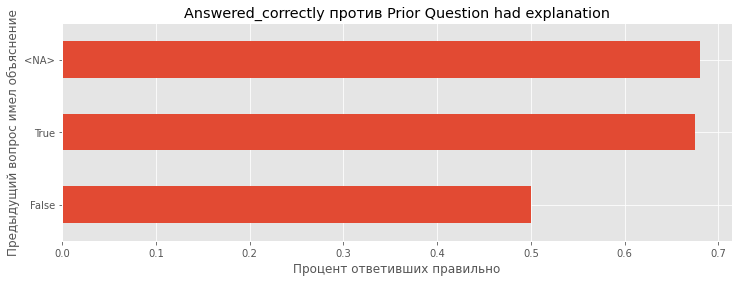

In [36]:
pq = data[data.answered_correctly != -1].groupby(['prior_question_had_explanation'], dropna=False).agg({'answered_correctly': ['mean', 'count']})
#pq.index = pq.index.astype(str)
print(pq.iloc[:,1])
pq = pq.iloc[:,0]

fig = plt.figure(figsize=(12,4))
pq.plot.barh()
# for i, v in zip(pq.index, pq.values):
# plt.text(v, i, round(v,2), color='white', fontweight='bold', fontsize=14, ha='right', va='center')
plt.title("Answered_correctly против Prior Question had explanation")
plt.xlabel("Процент ответивших правильно")
plt.ylabel("Предыдущий вопрос имел объяснение")
plt.xticks(rotation=0)
plt.show()

prior_question_elapsed_time: (float32) Среднее время в миллисекундах, которое потребовалось пользователю для ответа на каждый вопрос в предыдущей части вопросов, без учета всех лекций между ними. Является нулевым для первой части вопросов или лекции пользователя. Обратите внимание, что время - это среднее время, затраченное пользователем на решение каждого вопроса в предыдущей части.

На первый взгляд, это не очень интересно. Как для неправильных, так и для правильных ответов среднее значение составляет около 25 секунд.

In [39]:
pq = data[data.answered_correctly != -1]
pq = pq[['prior_question_elapsed_time', 'answered_correctly']]
pq = pq.groupby(['answered_correctly']).agg({'answered_correctly': ['count'], 'prior_question_elapsed_time': ['mean']})

pq

,answered_correctly,prior_question_elapsed_time
,count,mean
answered_correctly,,
0,3347179,25704.232422
1,6457425,25357.035156


Анализ таблицы с вопросами

In [40]:
questions.head()

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


In [41]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     13523 non-null  int64 
 1   bundle_id       13523 non-null  int64 
 2   correct_answer  13523 non-null  int64 
 3   part            13523 non-null  int64 
 4   tags            13522 non-null  object
dtypes: int64(4), object(1)
memory usage: 528.4+ KB


Таблица состоит из 13523 строк и 5 колонок.

In [42]:
questions.isna().sum()

question_id       0
bundle_id         0
correct_answer    0
part              0
tags              1
dtype: int64

Теги кажутся мне ценными. Сначала давайте проверим, есть ли вопросы без тегов. Как видите, есть ровно один question_id без тега.

In [43]:
questions[questions.tags.isna()]

,question_id,bundle_id,correct_answer,part,tags
10033,10033,10033,2,6,NaN


In [44]:
questions['tags'] = questions['tags'].astype(str)

tags = [x.split() for x in questions[questions.tags != "nan"].tags.values]
tags = [item for elem in tags for item in elem]
tags = set(tags)
tags = list(tags)
print(f'Есть {len(tags)} различных тегов')

Есть 188 различных тегов


Давайте выясним, сколько ответов было правильных и неправильных на question_id (то есть на content_id в data).

In [45]:
tags_list = [x.split() for x in questions.tags.values]
questions['tags'] = tags_list
questions.head()

correct = data[data.answered_correctly != -1].groupby(["content_id", 'answered_correctly'], as_index=False).size()
correct = correct.pivot(index= "content_id", columns='answered_correctly', values='size')
correct.columns = ['Wrong', 'Right']
correct = correct.fillna(0)
correct[['Wrong', 'Right']] = correct[['Wrong', 'Right']].astype(int)
questions = questions.merge(correct, left_on = "question_id", right_on = "content_id", how = "left")
questions.head()

,question_id,bundle_id,correct_answer,part,tags,Wrong,Right
0,0,0,0,1,"[51, 131, 162, 38]",63.0,628.0
1,1,1,1,1,"[131, 36, 81]",77.0,649.0
2,2,2,0,1,"[131, 101, 162, 92]",1970.0,2531.0
3,3,3,0,1,"[131, 149, 162, 29]",500.0,1776.0
4,4,4,3,1,"[131, 5, 162, 38]",1173.0,1980.0


Теперь я могу сложить все неправильные и правильные ответы для всех вопросов, помеченных определенным тегом, и рассчитать процент правильных ответов для каждого тега. Обратите внимание, что существует "двойной подсчет" вопросов: например, если вопрос имеет 5 тегов, его ответы суммируются в итоговых суммах по каждому из 5 тегов.

In [46]:
tags_df = pd.DataFrame()
for x in range(len(tags)):
    df = questions[questions.tags.apply(lambda l: tags[x] in l)]
    df1 = df.agg({'Wrong': ['sum'], 'Right': ['sum']})
    df1['Total_questions'] = df1.Wrong + df1.Right
    df1['Question_ids_with_tag'] = len(df)
    df1['tag'] = tags[x]
    df1 = df1.set_index('tag')
    tags_df = tags_df.append(df1)

tags_df[['Wrong', 'Right', 'Total_questions']] = tags_df[['Wrong', 'Right', 'Total_questions']].astype(int)
tags_df['Percent_correct'] = tags_df.Right/tags_df.Total_questions
tags_df = tags_df.sort_values(by = "Percent_correct")

tags_df.head()

,Wrong,Right,Total_questions,Question_ids_with_tag,Percent_correct
tag,,,,,
24,15523,9653,25176,17,0.383421
23,25673,20228,45901,11,0.440688
19,17267,13833,31100,57,0.444791
151,26954,25882,52836,16,0.489855
108,23213,23511,46724,20,0.503189


In [48]:
tags_df.shape

(188, 5)

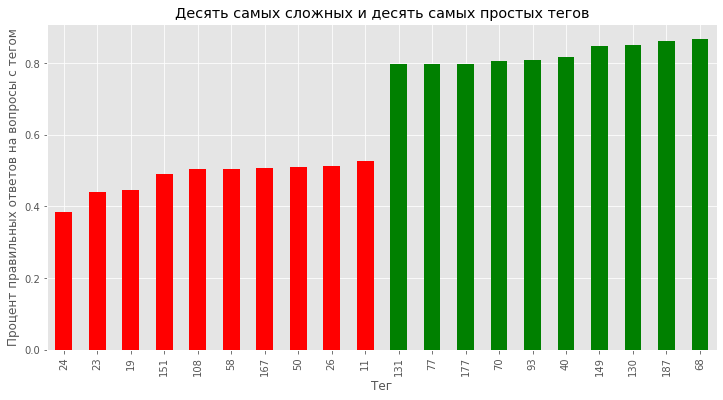

In [47]:
select_rows = list(range(0,10)) + list(range(178, len(tags_df)))
tags_select = tags_df.iloc[select_rows,4]

fig = plt.figure(figsize=(12,6))
x = tags_select.index
y = tags_select.values
clrs = ['red' if y < 0.6 else 'green' for y in tags_select.values]
tags_select.plot.bar(x, y, color=clrs)
plt.title("Десять самых сложных и десять самых простых тегов")
plt.xlabel("Тег")
plt.ylabel("Процент правильных ответов на вопросы с тегом")
plt.xticks(rotation=90)
plt.show()

Однако мы также должны понимать, что тег с наихудшим percent_correct имеет только около 250 000 ответов. Это небольшое число по сравнению с тегами с наибольшим количеством ответов.

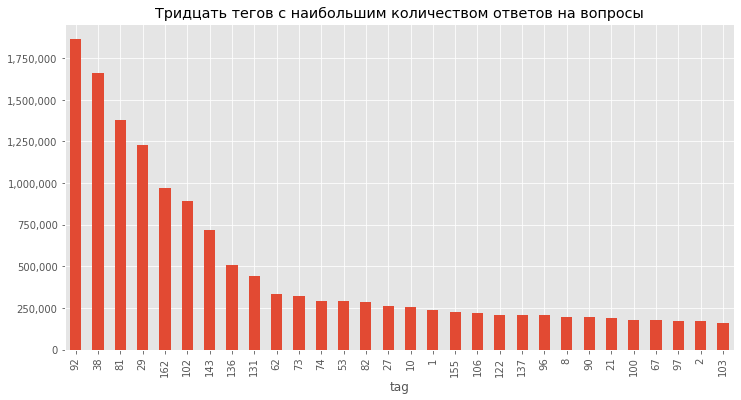

In [49]:
tags_select = tags_df.sort_values(by = "Total_questions", ascending = False).iloc[:30,:]
tags_select = tags_select["Total_questions"]

fig = plt.figure(figsize=(12,6))
ax = tags_select.plot.bar()
plt.title("Тридцать тегов с наибольшим количеством ответов на вопросы")
plt.xticks(rotation=90)
plt.ticklabel_format(style='plain', axis='y')
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ','))) #add thousands separator
plt.show()

Теперь посмотрим так называемые "Parts".

В TOEIC L&R используется оптически-сканируемый бланк ответов. За два часа необходимо ответить на 200 вопросов в разделах Listening (примерно 45 минут, 100 вопросов) и Reading (75 минут, 100 вопросов).

Раздел аудирования состоит из частей 1-4 (Секция аудирования (около 45 минут, 100 вопросов)).

Раздел по чтению состоит из частей 5-7 (Раздел по чтению (75 минут, 100 вопросов)).

Ниже я показываю количество и процент правильных ответов по частям. Как вы можете видеть, в части 5 гораздо больше вопросов и она также самая сложная.

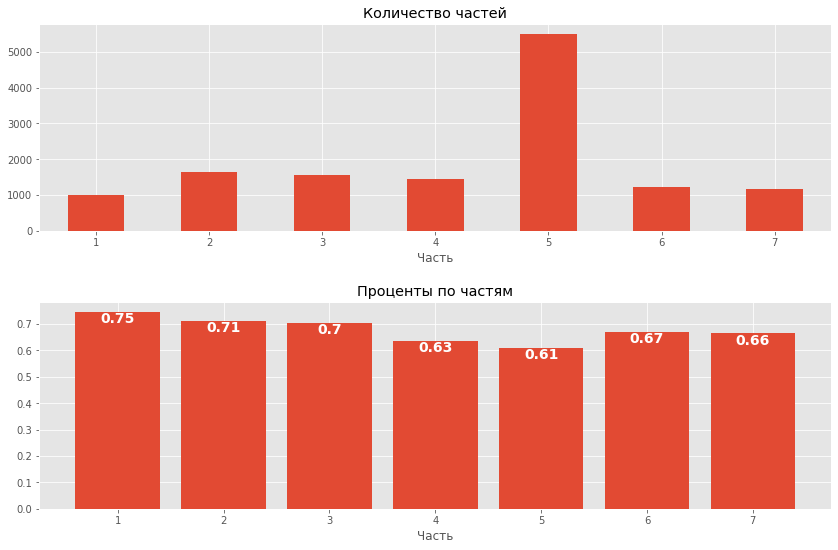

In [50]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
ax1 = questions.groupby("part").count()['question_id'].plot.bar()
plt.title("Количество частей")
plt.xlabel("Часть")
plt.xticks(rotation=0)

part = questions.groupby('part').agg({'Wrong': ['sum'], 'Right': ['sum']})
part['Percent_correct'] = part.Right/(part.Right + part.Wrong)
part = part.iloc[:,2]

ax2 = fig.add_subplot(212)
plt.bar(part.index, part.values)
for i, v in zip(part.index, part.values):
    plt.text(i, v, round(v,2), color='white', fontweight='bold', fontsize=14, va='top', ha='center')

plt.title("Проценты по частям")
plt.xlabel("Часть")
plt.xticks(rotation=0)
plt.tight_layout(pad=2)
plt.show()

Анализ таблицы с лекциями

In [51]:
lectures.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


In [52]:
print(f'Всего {lectures.shape[0]} лекций.')

Всего 418 лекций.


In [53]:
lectures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   lecture_id  418 non-null    int64 
 1   tag         418 non-null    int64 
 2   part        418 non-null    int64 
 3   type_of     418 non-null    object
dtypes: int64(3), object(1)
memory usage: 13.2+ KB


Таблица состоит из 418 строк и 4 уолонок.

In [54]:
lectures.isna().sum()

lecture_id    0
tag           0
part          0
type_of       0
dtype: int64

Давайте посмотрим на type_of.

In [56]:
lectures.type_of.value_counts()

concept             222
solving question    186
intention             7
starter               3
Name: type_of, dtype: int64

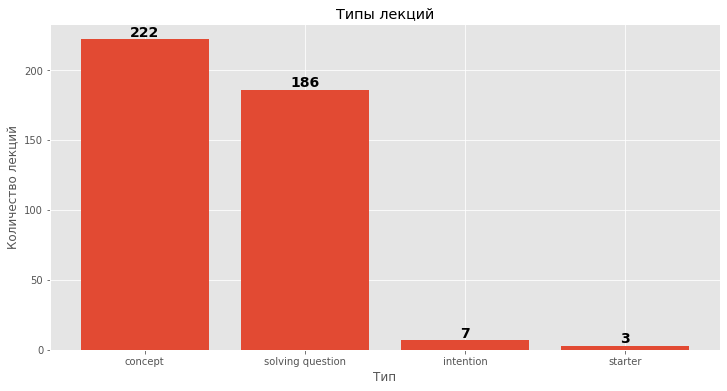

In [55]:
lect_type_of = lectures.type_of.value_counts()

fig = plt.figure(figsize=(12,6))
plt.bar(lect_type_of.index, lect_type_of.values)
for i, v in zip(lect_type_of.index, lect_type_of.values):
    plt.text(i, v, v, color='black', fontweight='bold', fontsize=14, va='bottom', ha='center')
plt.title("Типы лекций")
plt.xlabel("Тип")
plt.ylabel("Количество лекций")
plt.xticks(rotation=0)
plt.show()

Поскольку лекций не так много, я хочу проверить, помогает ли пользователю просмотр лекций вообще. Как вы можете видеть, это действительно помогает!

False    24467
True     15024
Name: Watches_lecture, dtype: int64


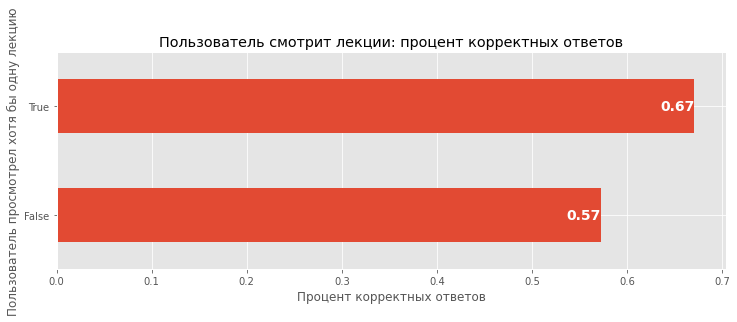

In [57]:
user_lect = data.groupby(["user_id", "answered_correctly"]).size().unstack()
user_lect.columns = ['Lecture', 'Wrong', 'Right']
user_lect['Lecture'] = user_lect['Lecture'].fillna(0)
user_lect = user_lect.astype('Int64')
user_lect['Watches_lecture'] = np.where(user_lect.Lecture > 0, True, False)

watches_l = user_lect.groupby("Watches_lecture").agg({'Wrong': ['sum'], 'Right': ['sum']})
print(user_lect.Watches_lecture.value_counts())

watches_l['Percent_correct'] = watches_l.Right/(watches_l.Right + watches_l.Wrong)

watches_l = watches_l.iloc[:,2]

fig = plt.figure(figsize=(12,4))
watches_l.plot.barh()
for i, v in zip(watches_l.index, watches_l.values):
    plt.text(v, i, round(v,2), color='white', fontweight='bold', fontsize=14, ha='right', va='center')

plt.title("Пользователь смотрит лекции: процент корректных ответов")
plt.xlabel("Процент корректных ответов")
plt.ylabel("Пользователь просмотрел хотя бы одну лекцию")
plt.xticks(rotation=0)
plt.show()

Части (task_container_id) могут также содержать лекции, и я хочу выяснить, есть ли части с большим количеством лекций.

In [58]:
batch_lect = data.groupby(["task_container_id", "answered_correctly"]).size().unstack()
batch_lect.columns = ['Lecture', 'Wrong', 'Right']
batch_lect['Lecture'] = batch_lect['Lecture'].fillna(0)
batch_lect = batch_lect.astype('Int64')
batch_lect['Percent_correct'] = batch_lect.Right/(batch_lect.Wrong + batch_lect.Right)
batch_lect['Percent_lecture'] = batch_lect.Lecture/(batch_lect.Lecture + batch_lect.Wrong + batch_lect.Right)
batch_lect = batch_lect.sort_values(by = "Percent_lecture", ascending = False)

print(f'Наибольшее количество лекций, просмотренных в рамках одного task_container_id, равно {batch_lect.Lecture.max()}.')

Наибольшее количество лекций, просмотренных в рамках одного task_container_id, равно 523.


Как вы можете видеть ниже (таблица отсортирована по убыванию Percent_lecture), процент лекций у task_container_id никогда не бывает высоким. 

In [59]:
batch_lect.head()

,Lecture,Wrong,Right,Percent_correct,Percent_lecture
task_container_id,,,,,
9651,2,4,10,0.714286,0.125
9034,2,5,12,0.705882,0.105263
9785,2,3,15,0.833333,0.1
8409,2,6,13,0.684211,0.095238
9596,2,10,9,0.473684,0.095238


Помогает ли наличие лекции в части? Как вы можете видеть, нет. В части без лекций примерно на 8% больше правильных ответов, чем в части с лекциями.

In [60]:
batch_lect['Has_lecture'] = np.where(batch_lect.Lecture == 0, False, True)
print(f'Мы имеем {batch_lect[batch_lect.Has_lecture == True].shape[0]} task_container_ids с лекциями и {batch_lect[batch_lect.Has_lecture == False].shape[0]} task_container_ids без лекций.')

Мы имеем 5979 task_container_ids с лекциями и 4021 task_container_ids без лекций.


In [61]:
batch_lect = batch_lect[['Wrong', 'Right', 'Has_lecture']]
batch_lect = batch_lect.groupby("Has_lecture").sum()
batch_lect['Percent_correct'] = batch_lect.Right/(batch_lect.Wrong + batch_lect.Right)
batch_lect = batch_lect[['Percent_correct']]
batch_lect

,Percent_correct
Has_lecture,
False,0.735944
True,0.656856
